In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess dataset
df = pd.read_csv("./data/BTCUSDT_1h.csv")
df['close_time'] = pd.to_datetime(df['close_time'], errors='coerce')
df.sort_values('close_time')
data = df[['open', 'high', 'low', 'close', 'volume']].values

In [4]:
# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
# Create sequences
SEQ_LEN = 24  # 24 hours
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        y = data[i+seq_len][3]  # Predict 'close'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, SEQ_LEN)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

In [6]:
# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)

In [7]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)              # out: [batch, seq_len, hidden]
        out = out[:, -1, :]                # last time step
        out = self.layer_norm(out)         # layer normalization
        out = self.dropout(out)            # apply dropout
        return self.fc(out)

model = LSTMModel(input_size=5, hidden_size=64, num_layers=2, dropout=0.3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
early_stopper_patience = 10

In [8]:
# Training loop
train_losses, val_losses, lrs, rmse_values, mae_values = [], [], [], [], []
best_val_loss = np.inf
patience_counter = 0

for epoch in range(100):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    model.eval()
    epoch_val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            epoch_val_loss += loss.item()
            preds.extend(pred.squeeze().tolist())
            targets.extend(yb.squeeze().tolist())

    rmse = np.sqrt(mean_squared_error(targets, preds))
    mae = mean_absolute_error(targets, preds)

    lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(epoch_val_loss / len(val_loader))
    lrs.append(lr)
    rmse_values.append(rmse)
    mae_values.append(mae)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, \n\tRMSE={rmse:.4f}, MAE={mae:.4f}, LR={lr:.5f}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopper_patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss=0.0381, Val Loss=0.0058, 
	RMSE=0.0763, MAE=0.0574, LR=0.01000
Epoch 2: Train Loss=0.0005, Val Loss=0.0020, 
	RMSE=0.0449, MAE=0.0320, LR=0.01000
Epoch 3: Train Loss=0.0004, Val Loss=0.0020, 
	RMSE=0.0453, MAE=0.0375, LR=0.01000
Epoch 4: Train Loss=0.0003, Val Loss=0.0013, 
	RMSE=0.0356, MAE=0.0229, LR=0.01000
Epoch 5: Train Loss=0.0003, Val Loss=0.0022, 
	RMSE=0.0468, MAE=0.0419, LR=0.01000
Epoch 6: Train Loss=0.0003, Val Loss=0.0013, 
	RMSE=0.0366, MAE=0.0243, LR=0.01000
Epoch 7: Train Loss=0.0003, Val Loss=0.0009, 
	RMSE=0.0302, MAE=0.0220, LR=0.01000
Epoch 8: Train Loss=0.0003, Val Loss=0.0016, 
	RMSE=0.0399, MAE=0.0319, LR=0.01000
Epoch 9: Train Loss=0.0003, Val Loss=0.0040, 
	RMSE=0.0631, MAE=0.0501, LR=0.01000
Epoch 10: Train Loss=0.0003, Val Loss=0.0026, 
	RMSE=0.0513, MAE=0.0347, LR=0.01000
Epoch 11: Train Loss=0.0003, Val Loss=0.0017, 
	RMSE=0.0417, MAE=0.0328, LR=0.01000
Epoch 12: Train Loss=0.0003, Val Loss=0.0011, 
	RMSE=0.0336, MAE=0.0218, LR=0.01000
E

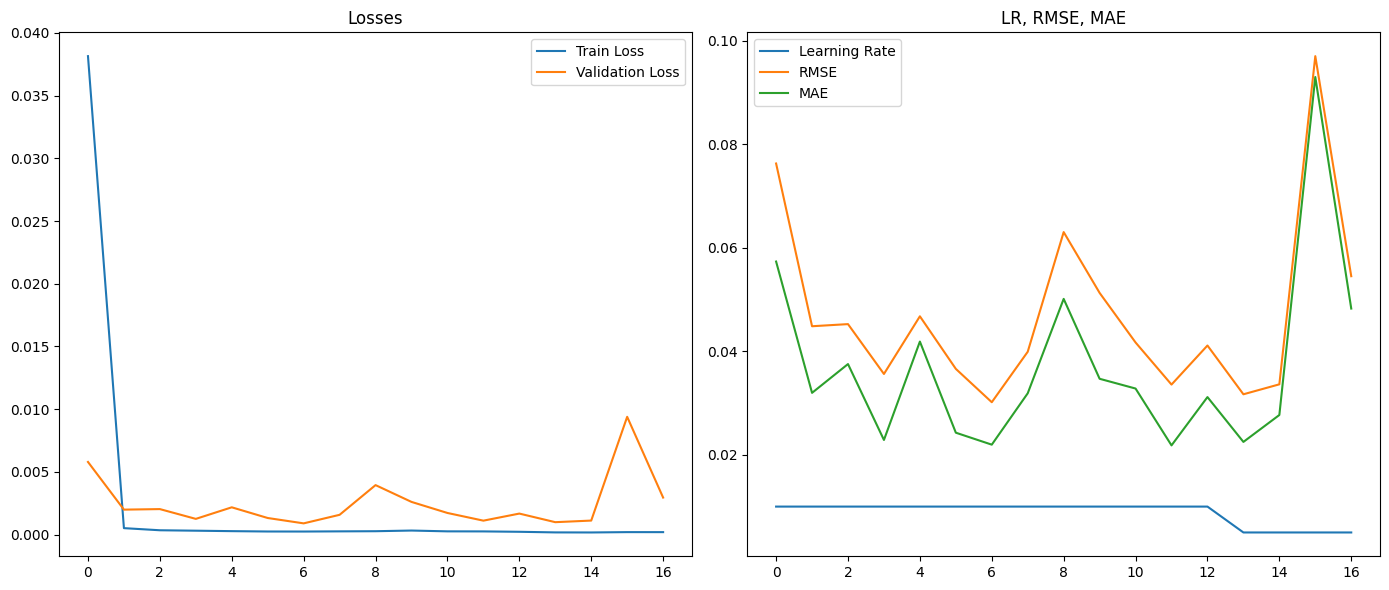

In [9]:
# Plot metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.plot(rmse_values, label='RMSE')
plt.plot(mae_values, label='MAE')
plt.legend()
plt.title('LR, RMSE, MAE')
plt.tight_layout()
plt.show()

Detected 206 anomalies using Z-score method.


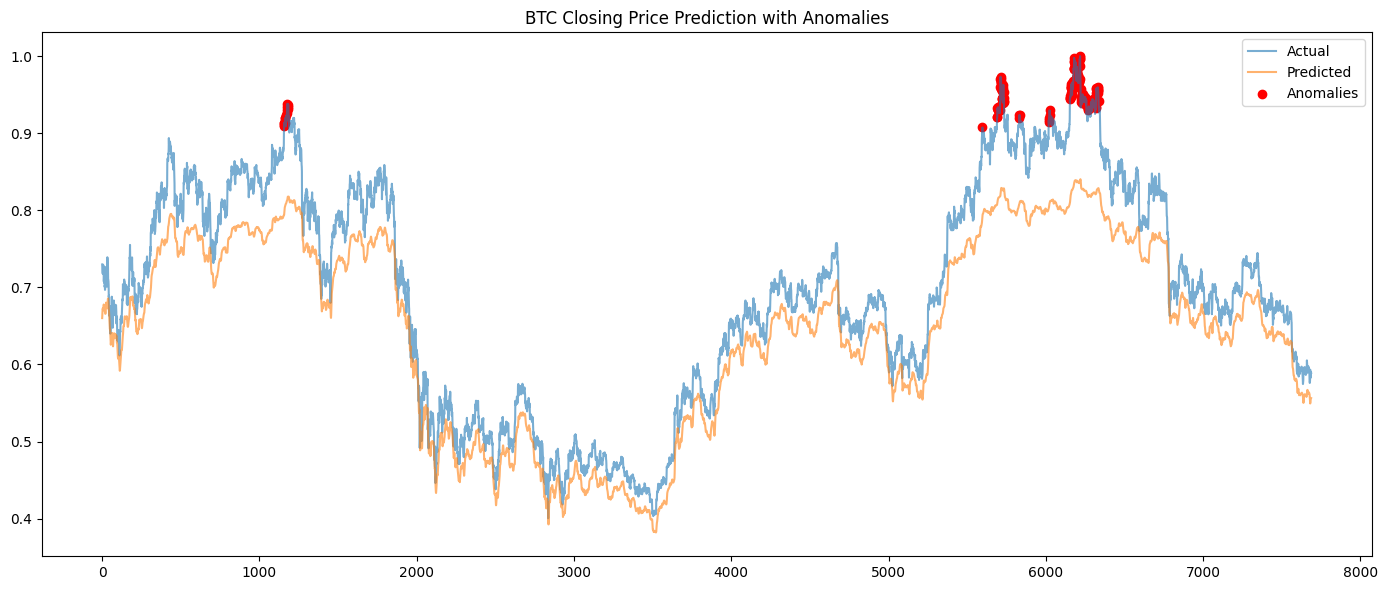

In [10]:
# Detect anomalies using Z-score of residuals
errors = np.abs(np.array(targets) - np.array(preds))
mean_error = np.mean(errors)
std_error = np.std(errors)
z_scores = (errors - mean_error) / std_error

anomaly_threshold = 2.5  # Can tune this
anomalies = np.where(np.abs(z_scores) > anomaly_threshold)[0]

print(f"Detected {len(anomalies)} anomalies using Z-score method.")

# Plot with anomalies
plt.figure(figsize=(14, 6))
plt.plot(targets, label='Actual', alpha=0.6)
plt.plot(preds, label='Predicted', alpha=0.6)
plt.scatter(anomalies, np.array(targets)[anomalies], color='red', label='Anomalies')
plt.title("BTC Closing Price Prediction with Anomalies")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
base_index = split + SEQ_LEN
anomaly_times = df['close_time'].iloc[base_index + anomalies]
for time in anomaly_times:
    print("Anomaly detected at:", time)


Anomaly detected at: 2021-04-13 03:59:59.999000-05:00
Anomaly detected at: 2021-04-13 04:59:59.999000-05:00
Anomaly detected at: 2021-04-13 05:59:59.999000-05:00
Anomaly detected at: 2021-04-13 06:59:59.999000-05:00
Anomaly detected at: 2021-04-13 07:59:59.999000-05:00
Anomaly detected at: 2021-04-13 10:59:59.999000-05:00
Anomaly detected at: 2021-04-13 12:59:59.999000-05:00
Anomaly detected at: 2021-04-13 18:59:59.999000-05:00
Anomaly detected at: 2021-04-13 22:59:59.999000-05:00
Anomaly detected at: 2021-04-13 23:59:59.999000-05:00
Anomaly detected at: 2021-04-14 00:59:59.999000-05:00
Anomaly detected at: 2021-04-14 01:59:59.999000-05:00
Anomaly detected at: 2021-04-14 02:59:59.999000-05:00
Anomaly detected at: 2021-04-14 05:59:59.999000-05:00
Anomaly detected at: 2021-04-14 06:59:59.999000-05:00
Anomaly detected at: 2021-10-15 15:59:59.999000-05:00
Anomaly detected at: 2021-10-19 12:59:59.999000-05:00
Anomaly detected at: 2021-10-19 13:59:59.999000-05:00
Anomaly detected at: 2021-10

In [12]:
anomaly_df = df.iloc[base_index + anomalies].copy()
anomaly_df['predicted_close'] = np.array(preds)[anomalies]
anomaly_df['actual_close'] = np.array(targets)[anomalies]
anomaly_df['abs_error'] = np.abs(anomaly_df['actual_close'] - anomaly_df['predicted_close'])

anomaly_df.to_csv("lstm_anomalies2.csv", index=False)
print("Anomalies saved to btc_anomalies.csv")


Anomalies saved to btc_anomalies.csv


In [13]:
df2 = pd.read_csv("lstm_anomalies2.csv")

In [14]:
df2.head()

,open,high,low,close,volume,close_time,quote,takers_buy_base,takers_buy_quote,predicted_close,actual_close,abs_error
0,61050.99,62878.00,61046.45,62711.51,11272.865488,2021-04-13 03:59:59.999000-05:00,7.022088e+08,6269.806143,3.903930e+08,0.793523,0.909880,0.116357
1,62711.51,63287.88,62300.88,62924.24,6333.624079,2021-04-13 04:59:59.999000-05:00,3.975447e+08,3605.461764,2.263464e+08,0.794345,0.913118,0.118773
2,62924.23,63100.00,62458.00,62745.56,4400.767576,2021-04-13 05:59:59.999000-05:00,2.760403e+08,2191.675626,1.374780e+08,0.796925,0.910399,0.113474
3,62745.56,63093.82,62500.00,62942.21,3337.013558,2021-04-13 06:59:59.999000-05:00,2.096540e+08,1549.536054,9.735709e+07,0.799723,0.913391,0.113668
4,62942.21,63260.00,62790.85,62973.25,4125.909956,2021-04-13 07:59:59.999000-05:00,2.598547e+08,1754.848356,1.105400e+08,0.802088,0.913863,0.111775
